In [1]:
import os
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

from datasets import load_from_disk
from matplotlib import pyplot as plt
# from peft import PeftModel
from utils import *

os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2"

/data5/aamayuelasfernandez/miniconda3/envs/fingpt-py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model = AutoModelForCausalLM.from_pretrained(
    'meta-llama/Llama-2-7b-chat-hf',
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16,   
)
base_model.model_parellal = True

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


In [3]:
from peft import PeftModel

model = PeftModel.from_pretrained(base_model, 'finetuned_models/dow30-2023-llama2-5e-5lr-qkvogud_202401181618')
model = model.eval()

In [4]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')
tokenizer.padding_side = "right"
tokenizer.pad_token_id = tokenizer.eos_token_id

In [5]:
test_dataset = load_from_disk('data/fingpt-forecaster-dow-30-20221231-20231231-1-4-08')['test']

symbol = 'AAPL'
test_dataset = test_dataset.filter(lambda x: x['symbol'] == symbol)

In [6]:
test_dataset

Dataset({
    features: ['prompt', 'answer', 'period', 'label', 'symbol'],
    num_rows: 10
})

In [7]:
def test_demo(model, tokenizer, prompt):

    inputs = tokenizer(
        prompt, return_tensors='pt',
        padding=False, max_length=4096
    )
    inputs = {key: value.to(model.device) for key, value in inputs.items()}
        
    res = model.generate(
        **inputs, max_length=4096, do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=True
    )
    output = tokenizer.decode(res[0], skip_special_tokens=True)
    return output    
    # return res

In [8]:
def from_bin_to_margin(pred):
    if re.search(r'up|increase', pred.lower()):
        pred_bin = 1
    elif re.search(r'down|decrease|decline', pred.lower()):
        pred_bin = -1
    else:
        pred_bin = 0

    match_res = re.search(r'(\d)-(\d)%', pred)
    if not match_res:
        match_res = re.search(r'(?:more than )?(\d)+?%', pred)

    pred_margin = pred_bin * (int(match_res.group(1)) + 0.5) if match_res else 0
    return pred_margin, pred_bin

In [9]:
answers, gts = [], []

prediction, prediction_binary = [], []
gt_prediction, gt_prediction_binary = [], []

for i in tqdm(range(len(test_dataset))):
    prompt = test_dataset[i]['prompt']
    output = test_demo(base_model, tokenizer, prompt)
    answer = re.sub(r'.*\[/INST\]\s*', '', output, flags=re.DOTALL)
    # print('\n------- Prompt ------\n')
    # print(prompt)
    # print('\n------- LLaMA2 Finetuned ------\n')
    # print(answer)
    # print('\n------- GPT4 Groundtruth ------\n')
    # print(gt)
    # print('\n===============\n')
    answers.append(answer)

100%|██████████| 10/10 [04:52<00:00, 29.24s/it]


In [10]:
gt_predictions, gt_predictions_binary = [], []
for i in tqdm(range(len(test_dataset))):
    label = test_dataset[i]['label']
    gt_prediction, gt_prediction_binary = from_bin_to_margin(label)

    gt_predictions.append(gt_prediction)
    gt_predictions_binary.append(gt_prediction_binary)

100%|██████████| 10/10 [00:00<00:00, 3263.03it/s]


In [17]:
parsed_answers = [parse_answer(answer) for answer in answers]

In [18]:
cnt = 0
for i in range(len(parsed_answers)):
    if parsed_answers[i] == None:
        cnt += 1

In [19]:
cnt

0

In [20]:
df = test_dataset.to_pandas()

parsed_answers = [parse_answer(answer) for answer in answers]
predictions = [answer['prediction'] if answer else 0 for answer in parsed_answers]
predictions_binary = [answer['prediction_binary'] if answer else 0 for answer in parsed_answers]

df['gt_prediction'] = gt_predictions
df['gt_prediction_binary'] = gt_predictions_binary
df['generated_answer'] = answers
df['prediction'] = predictions
df['prediction_binary'] = predictions_binary

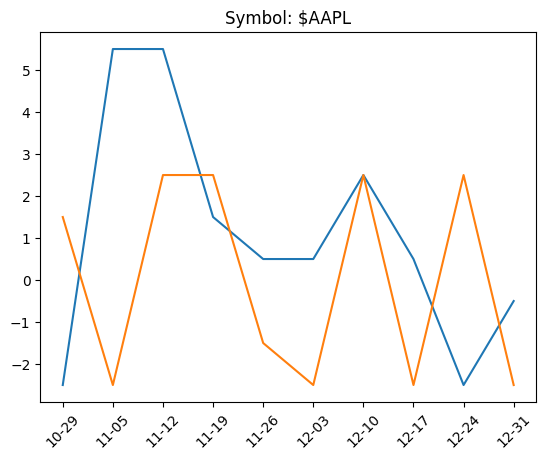

In [21]:
plt.plot(df['period'].apply(lambda x: x[-5:]), df['gt_prediction'])
plt.plot(df['period'].apply(lambda x: x[-5:]), df['prediction'])
plt.title(f'Symbol: ${symbol}')
plt.xticks(rotation=45)
plt.show()

In [22]:
correlation_coeff = np.corrcoef(df['gt_prediction'], df['prediction'])[0, 1]
print(f'Correlation Coefficient: {correlation_coeff}')

mse = np.mean((df['gt_prediction'] - df['prediction']) ** 2)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mae = np.mean(np.abs(df['gt_prediction'] - df['prediction']))
print(f'MAE: {mae}')

Correlation Coefficient: -0.03228831748798894
MSE: 14.1
RMSE: 3.7549966711037173
MAE: 3.1


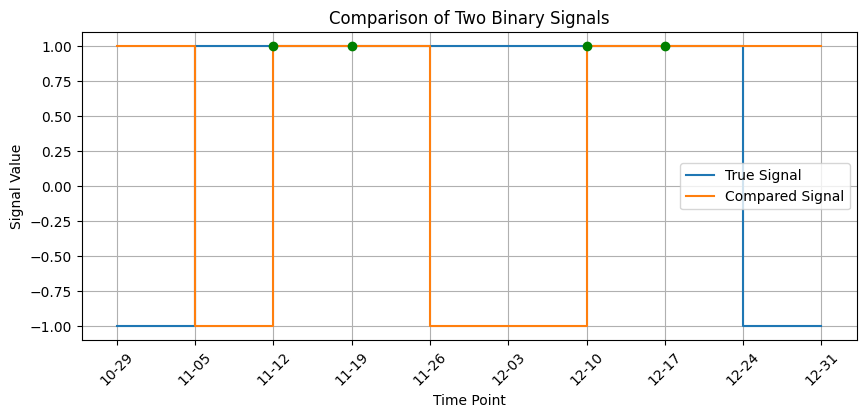

In [29]:
time_points = df['period'].apply(lambda x: x[-5:])
true_signal = df['gt_prediction_binary']
compared_signal = df['prediction_binary']

plt.figure(figsize=(10, 4))
plt.plot(time_points, true_signal, label='True Signal', drawstyle='steps-post')
plt.plot(time_points, compared_signal, label='Compared Signal', drawstyle='steps-post')

# Highlight where the signals match
for i, (t, c) in enumerate(zip(true_signal, compared_signal)):
    if t == c:
        plt.plot(i, t, 'go')  # 'go' means green circle

plt.xlabel('Time Point')
plt.ylabel('Signal Value')
plt.title('Comparison of Two Binary Signals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [20]:
correct_bin = sum(df['gt_prediction_binary'] == df['prediction_binary']) / len(df)
print(f'Correct Binary: {correct_bin}')

Correct Binary: 0.5


In [19]:
df.to_csv(f'./results/finetuned-{symbol}.csv', index=False, )